# **\[Essays\]** 강화학습 v4

신록예찬  
2023-08-12

# imports

In [28]:
import gymnasium as gym
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
import torch 
import collections
import IPython
import random

# 기존알고리즘

In [29]:
BUFFER_SIZE = 500*20   # replay buffer size
BATCH_SIZE = 128     # minibatch size
GAMMA = 0.99          # discount factor

In [30]:
class ReplayBuffer:
    """Fixed-size buffer to store experience tuples."""

    def __init__(self):
        """Initialize a ReplayBuffer object.

        Params
        ======
            action_size (int): dimension of each action
            buffer_size (int): maximum size of buffer
            batch_size (int): size of each training batch
            seed (int): random seed
        """
        self.action_size = 4
        self.memory = collections.deque(maxlen=BUFFER_SIZE)  
        self.batch_size = BATCH_SIZE
        self.experience = collections.namedtuple("Experience", field_names=["state", "action", "reward", "next_state", "done"])
    
    def add(self, state, action, reward, next_state, done):
        """Add a new experience to memory."""
        e = self.experience(state, action, reward, next_state, done)
        self.memory.append(e)
    
    def sample(self):
        """Randomly sample a batch of experiences from memory."""
        experiences = random.sample(self.memory, k=self.batch_size)
        
        # Convert to torch tensors
        states = torch.from_numpy(np.vstack([e.state for e in experiences if e is not None])).float()
        actions = torch.from_numpy(np.vstack([e.action for e in experiences if e is not None])).long()
        rewards = torch.from_numpy(np.vstack([e.reward for e in experiences if e is not None])).float()
        next_states = torch.from_numpy(np.vstack([e.next_state for e in experiences if e is not None])).float()
        
        # Convert done from boolean to int
        dones = torch.from_numpy(np.vstack([e.done for e in experiences if e is not None]).astype(np.uint8)).float()
        
        return (states, actions, rewards, next_states, dones)

    def __len__(self):
        """Return the current size of internal memory."""
        return len(self.memory)

In [41]:
class Agent():
    """Interacts with and learns from the environment."""

    def __init__(self,env):
        """Initialize an Agent object.
        
        Params
        ======
            state_size (int): dimension of each state
            action_size (int): dimension of each action
            seed (int): random seed
        """
        self.state_size = 8
        self.action_size = 4
        self.seed = 0 
        self.eps = 0

        # Q-Network
        self.net = torch.nn.Sequential(
            torch.nn.Linear(8,128), # 8은 state_size
            torch.nn.ReLU(),
            torch.nn.Linear(128,64),
            torch.nn.ReLU(),
            torch.nn.Linear(64,32),
            torch.nn.ReLU(),
            torch.nn.Linear(32,4)) # 4는 action_size 
        self.optimizer = torch.optim.Adam(self.net.parameters(), lr=0.0001)

        # Replay memory
        self.memory = ReplayBuffer()
    def step(self):
        self.current_state = self.next_state 
        self.score += self.reward        
    def act(self):
        """Returns actions for given state as per current policy.
        
        Params
        ======
            state (array_like): current state
            eps (float): epsilon, for epsilon-greedy action selection
        """
        state = torch.from_numpy(self.current_state).float().unsqueeze(0)
        action_values = self.net(state)            

        if np.random.rand() > self.eps:
            self.action = np.argmax(action_values.data.numpy())
        else:
            self.action = random.choice(np.arange(self.action_size))

    def __mul__(self,env): 
        self.next_state, self.reward, self.terminated, _, _ = env.step(self.action)
        self.memory.add(self.current_state, self.action, self.reward, self.next_state, self.terminated)

    def learn(self, experiences):
        """Update value parameters using given batch of experience tuples.

        Params
        ======
            experiences (Tuple[torch.Variable]): tuple of (s, a, r, s', done) tuples 
            gamma (float): discount factor
        """
        # Obtain random minibatch of tuples from D
        states, actions, rewards, next_states, dones = experiences

        ## Compute and minimize the loss
        q_targets_next = self.net(next_states).detach().max(1)[0].unsqueeze(1)
        q_targets = rewards + GAMMA * q_targets_next * (1 - dones)

        ### Calculate expected value from local network
        q_expected = self.net(states).gather(1, actions)
        
        loss = torch.nn.functional.mse_loss(q_expected, q_targets)
        
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

    def reset(self,env): 
        self.current_state, _ = env.reset()
        self.score = 0 

In [32]:
env = gym.make('LunarLander-v2',render_mode='rgb_array')

In [33]:
agent = Agent(env)

In [35]:
n_episodes = 2000
max_t = 500
eps_start = 1.0 
eps_end = 0.01
eps_decay = 0.995

playtimes=[] 
scores = []                        # list containing scores from each episode
scores_window = collections.deque(maxlen=100)  # last 100 scores
agent.eps = eps_start                    # initialize epsilon
for i_episode in range(1, n_episodes+1):
    agent.reset(env) 
    for t in range(max_t):
        ## STEP1: 
        agent.act()
        
        ## STEP2: 
        agent * env 
        
        ## STEP3: 
        if len(agent.memory) > BATCH_SIZE:
            agent.learn(agent.memory.sample())
        
        agent.step()
        
        ## STEP4: 
        if agent.terminated:
            playtimes.append(t)
            break 
    scores_window.append(agent.score)       # save most recent score
    scores.append(agent.score)              # save most recent score
    agent.eps = max(eps_end, eps_decay*agent.eps) # decrease epsilon
    print('\rEpisode {}\tAverage Score: {:.2f}\tPlaytime: {:.2f}'.format(i_episode, np.mean(scores_window), np.mean(playtimes)), end="")
    if i_episode % 100 == 0:
        print('\rEpisode {}\tAverage Score: {:.2f}\tPlaytime: {:.2f}'.format(i_episode, np.mean(scores_window), np.mean(playtimes)))
        torch.save(agent.net.state_dict(), 'checkpoint.pth')
    if np.mean(scores_window)>=200.0:
        print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)))
        torch.save(agent.net.state_dict(), 'checkpoint.pth')
        break

Episode 100 Average Score: -104.50  Playtime: 107.27
Episode 200 Average Score: 14.74    Playtime: 123.6715
Episode 300 Average Score: 95.07    Playtime: 132.05
Episode 400 Average Score: 129.87   Playtime: 158.84
Episode 500 Average Score: 160.02   Playtime: 187.56
Episode 538 Average Score: 200.83   Playtime: 197.94
Environment solved in 538 episodes! Average Score: 200.83

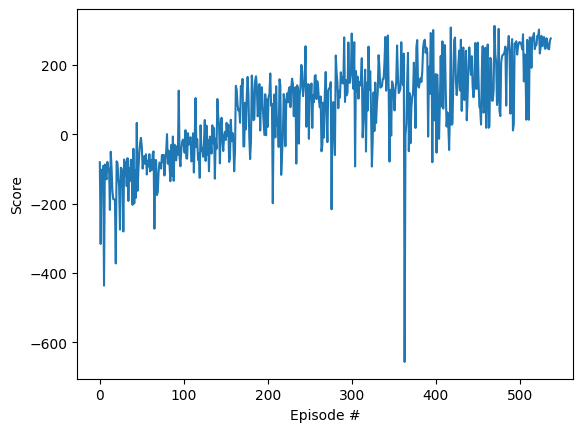

In [36]:
plt.plot(scores)
plt.ylabel('Score')
plt.xlabel('Episode #')

In [42]:
env = gym.make('LunarLander-v2',render_mode='rgb_array')
frames = []
agent = Agent(env)
agent.net.load_state_dict(torch.load('checkpoint.pth'))
agent.reset(env)
agent.terminated = False

while not agent.terminated:
    frames.append(env.render())
    agent.act()
    agent * env 
    agent.step()

env.close()

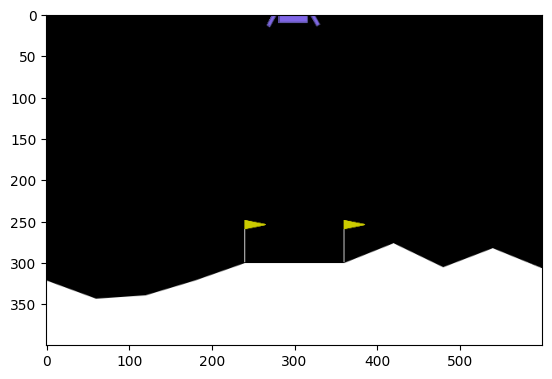

In [43]:
fig, ax = plt.subplots()
ani = FuncAnimation(fig,lambda i: ax.imshow(frames[::10][i]),frames=len(frames[::10]))

`-` 방법1

In [44]:
# ani.save('LunarLander-v2.mp4', writer='ffmpeg', fps=15, extra_args=['-vcodec', 'mpeg4'])

`-` 방법2

In [45]:
IPython.display.HTML(ani.to_jshtml())